In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0
import sys; sys.path.append('.')

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import numpy as np
from vocab import Vocab
voc = Vocab.from_file("../data/data_4000_bpe_train_val/2.voc")

In [3]:
import tensorflow as tf
import models.transformer as tr
from lib.tensor_utils import infer_length, infer_mask

tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction=0.333

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

mini_hp = {
        'hid_size': 256,
        'ff_size': 1024,
        'num_heads': 4,
        'num_layers': 4,
    
        'rescale_emb': True,
        'relu_dropout': 0.,
        'res_dropout': 0.,
        'attn_dropout': 0.,
        'inp_emb_bias': True,
        'res_steps': 'nlda',
        'normalize_out': True,
        'force_bos': True,
}




/home/user32878/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [5]:
from lib.transformer_layers import TransformerEncoder
from lib.layers import Dense
from lib.tensor_utils import infer_mask, infer_length

class TransformerLM:
    
    def __init__(self, name, voc, **hp):
        self.voc = voc
        self.name= name
        assert hp['force_bos'] is True, "this is build with force_bos in mind"
        
        with tf.variable_scope(name):
            self.enc = TransformerEncoder('main', inp_voc=voc, allow_lookahead=False, **hp)
            self.logits = Dense('logits', self.enc.hid_size, len(voc))
            
    def __call__(self, inp, is_train=False, after_eos=False):
        mask = infer_mask(inp, self.voc.eos, dtype=tf.float32)
        inp_len = infer_length(inp, self.voc.eos)
        
        enc_out, _ = self.enc(inp, is_train=is_train)
        
        logits = self.logits(enc_out)
        
        # shift logits forward
        if not after_eos:
            logits = logits[:,:-1]
            
        logits = tf.concat([tf.one_hot(inp[:, :1], len(self.voc)) * 100, logits], axis=1)
        return logits
    
#with tf.variable_scope('', reuse=True):
#    lm = TransformerLM('lm', voc, **mini_hp)

In [6]:
lines = open("../data/bpe_corpus2.txt").read().split('\n')[:-1]

In [7]:
_dummy = np.arange(5,30, dtype='int32').reshape([5,5])
inp = tf.placeholder_with_default(_dummy, [None,None])

In [9]:
lm = TransformerLM('lm', voc, **mini_hp)

In [10]:
logits = lm(inp, is_train=True)

In [11]:
from lib.tensor_utils import infer_mask, initialize_uninitialized_variables

nll = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=inp)

loss = nll * infer_mask(inp, voc.eos, dtype=tf.float32)

loss = tf.reduce_sum(loss, axis=1)
loss = tf.reduce_mean(loss)

In [12]:
weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, lm.name)
grads = tf.gradients(loss, weights)
grads = tf.clip_by_global_norm(grads, 100)[0]
train_step = tf.train.AdamOptimizer(learning_rate=1e-4, beta2=0.98).apply_gradients(zip(grads,weights))

In [13]:
sess.run(tf.global_variables_initializer())

In [14]:
initialize_uninitialized_variables(sess)

In [15]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import count
from pandas import ewma
from tqdm import tqdm
from time import sleep
epoch = 0
loss_history = []

In [16]:
order = {line: len(line) * (1 + np.random.normal(0, 0.2)) for line in lines}
lines = sorted(lines, key = lambda line: order[line])
lines = np.array(lines)

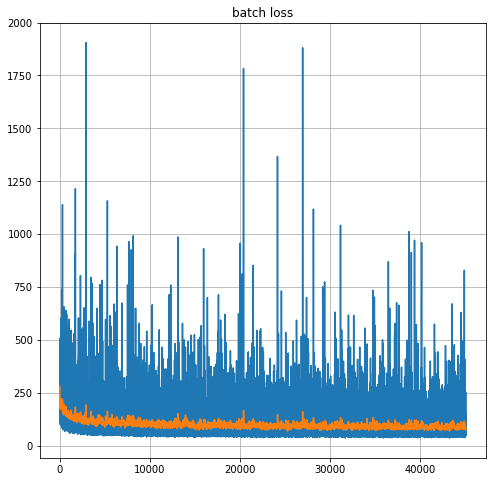

 45%|████▍     | 44879/100000 [2:18:06<2:49:38,  5.42it/s]


KeyboardInterrupt: 

In [18]:
batch_size = 32

for i in tqdm(range(10**5)):
    index = np.random.randint(0, len(lines) - batch_size)
    batch = lines[index: index + batch_size]
    batch_ix = voc.tokenize_many(batch)
    
    feed_dict = {inp: batch_ix}
    
    loss_t = sess.run([train_step, loss], feed_dict)[1]
    loss_history.append(np.mean(loss_t))
    
        
    if (epoch+1) % 500 == 0:
        w_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=lm.name)
        w_values = sess.run(w_variables)
        weights_dict = {w.name: w_val for w, w_val in zip(w_variables,w_values)}
        np.savez("../pretrained/lm_default_params_trg-%i.npz"%epoch, **weights_dict)
        
        order = {line: len(line) * (1 + np.random.normal(0, 0.2)) for line in lines}
        lines = sorted(lines, key = lambda line: order[line])
        lines = np.array(lines)
        
    
    if epoch % 10 == 0:
        clear_output(True)
        plt.figure(figsize=[8,8])
        plt.title("batch loss")
        plt.plot(loss_history)
        plt.plot(ewma(np.array(loss_history),span=50))
        plt.grid()
        plt.show()
    epoch +=1
        

In [19]:
weights_dict.keys()

dict_keys(['lm/main/emb_inp/mat:0', 'lm/main/enc_attn-0/mem_conv/W:0', 'lm/main/enc_attn-0/mem_conv/b:0', 'lm/main/enc_attn-0/out_conv/W:0', 'lm/main/enc_attn-0/out_conv/b:0', 'lm/main/enc_attn-0/layer_norm/scale:0', 'lm/main/enc_attn-0/layer_norm/bias:0', 'lm/main/enc_ffn-0/conv1/W:0', 'lm/main/enc_ffn-0/conv1/b:0', 'lm/main/enc_ffn-0/conv2/W:0', 'lm/main/enc_ffn-0/conv2/b:0', 'lm/main/enc_ffn-0/layer_norm/scale:0', 'lm/main/enc_ffn-0/layer_norm/bias:0', 'lm/main/enc_out_norm/scale:0', 'lm/main/enc_out_norm/bias:0', 'lm/logits/W:0', 'lm/logits/b:0'])

In [96]:
order = {line: len(line) * (1 + np.random.normal(0, 0.2)) for line in lines}
lines = sorted(lines, key = lambda line: order[line])
lines = np.array(lines)

In [100]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
batches = list(chunks(lines, batch_size))
from random import shuffle
shuffle(batches)

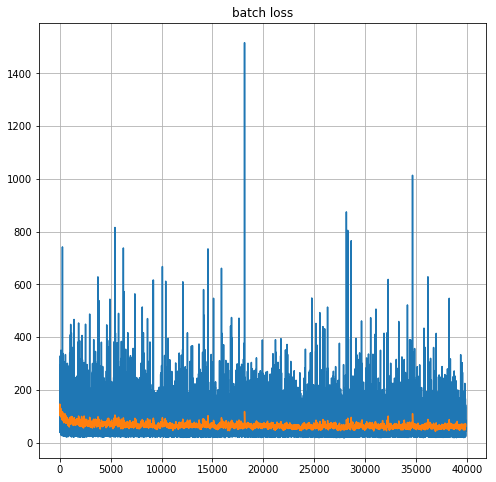

100%|██████████| 31250/31250 [1:22:13<00:00,  6.33it/s]


In [103]:
batch_size = 32

for batch in tqdm(batches):
    batch_ix = voc.tokenize_many(batch)
    
    feed_dict = {inp: batch_ix}
    
    loss_t = sess.run([train_step, loss], feed_dict)[1]
    loss_history.append(np.mean(loss_t))
    
        
    if (epoch+1) % 500 == 0:
        w_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=lm.name)
        w_values = sess.run(w_variables)
        weights_dict = {w.name: w_val for w, w_val in zip(w_variables,w_values)}
        np.savez("../pretrained/lm_default_params-%i.npz"%epoch, **weights_dict)
        
        order = {line: len(line) * (1 + np.random.normal(0, 0.2)) for line in lines}
        lines = sorted(lines, key = lambda line: order[line])
        lines = np.array(lines)
        
    
    if epoch % 10 == 0:
        clear_output(True)
        plt.figure(figsize=[8,8])
        plt.title("batch loss")
        plt.plot(loss_history)
        plt.plot(ewma(np.array(loss_history),span=50))
        plt.grid()
        plt.show()
    epoch +=1
        

In [58]:
np.random.choice(range(len(voc)), p =  tf.nn.softmax(logits).eval(feed_dict)[0][-1])

24

In [32]:
voc.tokenize(lines[0])

[0, 309, 3487, 528, 453, 2189, 2044, 1]

In [94]:
def sample(max_len):
    seq = np.array([[0, np.random.randint(3, len(voc))]])
    logits = lm(inp, is_train=False, after_eos=True)
    
    for i in range(10):
        feed_dict = {inp : seq}
        #print(tf.nn.softmax(logits).eval(feed_dict)[0][-1])
        el = np.random.choice(range(len(voc)), p =  tf.nn.softmax(logits * 10).eval(feed_dict)[0][-1])
        #print(el)
        seq = np.concatenate((seq, np.array([[el]])), 1)
    return seq[0]

In [104]:
for i in range(20):
    print(voc.detokenize(sample(15)))

__BOS__ landsca@@ pe , the view , the location , the room
__BOS__ spectacular view from the room and the room was very clean
__BOS__ zy , clean , very friendly staff , good location ,
__BOS__ ently priced , very good value for money . __EOS__
__BOS__ ino staff were very friendly and helpful . __EOS__
__BOS__ fu@@ s@@ sy and clean . __EOS__
__BOS__ exactly as descri@@ bed , very comfortable , clean and comfortable
__BOS__ 🙌 was very good , and the staff were very friendly
__BOS__ tain@@ er was good . __EOS__
__BOS__ regular shuttle to the airport . __EOS__
__BOS__ ees were very friendly and helpful . __EOS__
__BOS__ who was very friendly and helpful . __EOS__
__BOS__ Oc@@ ean view , very clean , comfortable , good breakfast
__BOS__ my@@ e@@ m@@ my is a very nice place to stay
__BOS__ Fea@@ ther was very helpful and friendly . __EOS__


KeyboardInterrupt: 

In [106]:
w_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=lm.name)
w_values = sess.run(w_variables)
weights_dict = {w.name: w_val for w, w_val in zip(w_variables,w_values)}
np.savez("../pretrained/lm_default_params-final_1.npz", **weights_dict)